In [2]:
# Investigation an issue related CI-test in PC algorithm.

In [3]:
from multiprocessing import cpu_count
import sys
import networkx as nx

sys.path.append('../')
from tsdr import tsdr
from diagnoser import diag
from diagnoser.diag import prepare_init_graph, filter_by_target_metrics
from meltria import loader
import diagnoser.metric_node as mn
import eval.priorknowledge as pk

filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-user_pod-memory-hog_1.json'
data_df, mappings = loader.read_metrics_file(filepath)

reducer = tsdr.Tsdr(tsdr.ar_based_ad_model, **{
    'tsifter_step1_ar_regression': 'n',
    'tsifter_step1_ar_anomaly_score_threshold': 0.01,
    'tsifter_step1_cv_threshold': 0.05,
    'tsifter_step1_ar_dynamic_prediction': False,
    'tsifter_step2_clustering_threshold': 0.01,
    'tsifter_step2_clustered_series_type': 'raw',
    'tsifter_step2_clustering_dist_type': 'sbd',
    'tsifter_step2_clustering_choice_method': 'medoid',
    'tsifter_step2_clustering_linkage_method': 'single',
})
_, reduced_df_by_step, metrics_dimension, _ = reducer.run(
    series=data_df,
    max_workers=cpu_count(),
)
reduced_df = reduced_df_by_step['step2']

dataset = filter_by_target_metrics(reduced_df)
nodes: mn.MetricNodes = mn.MetricNodes.from_dataframe(dataset)
init_g: nx.Graph = prepare_init_graph(nodes, mappings)


/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


True [<diagnoser.metric_node.MetricNodes object at 0x7f3e939313d0>]
DiGraph with 22 nodes and 27 edges


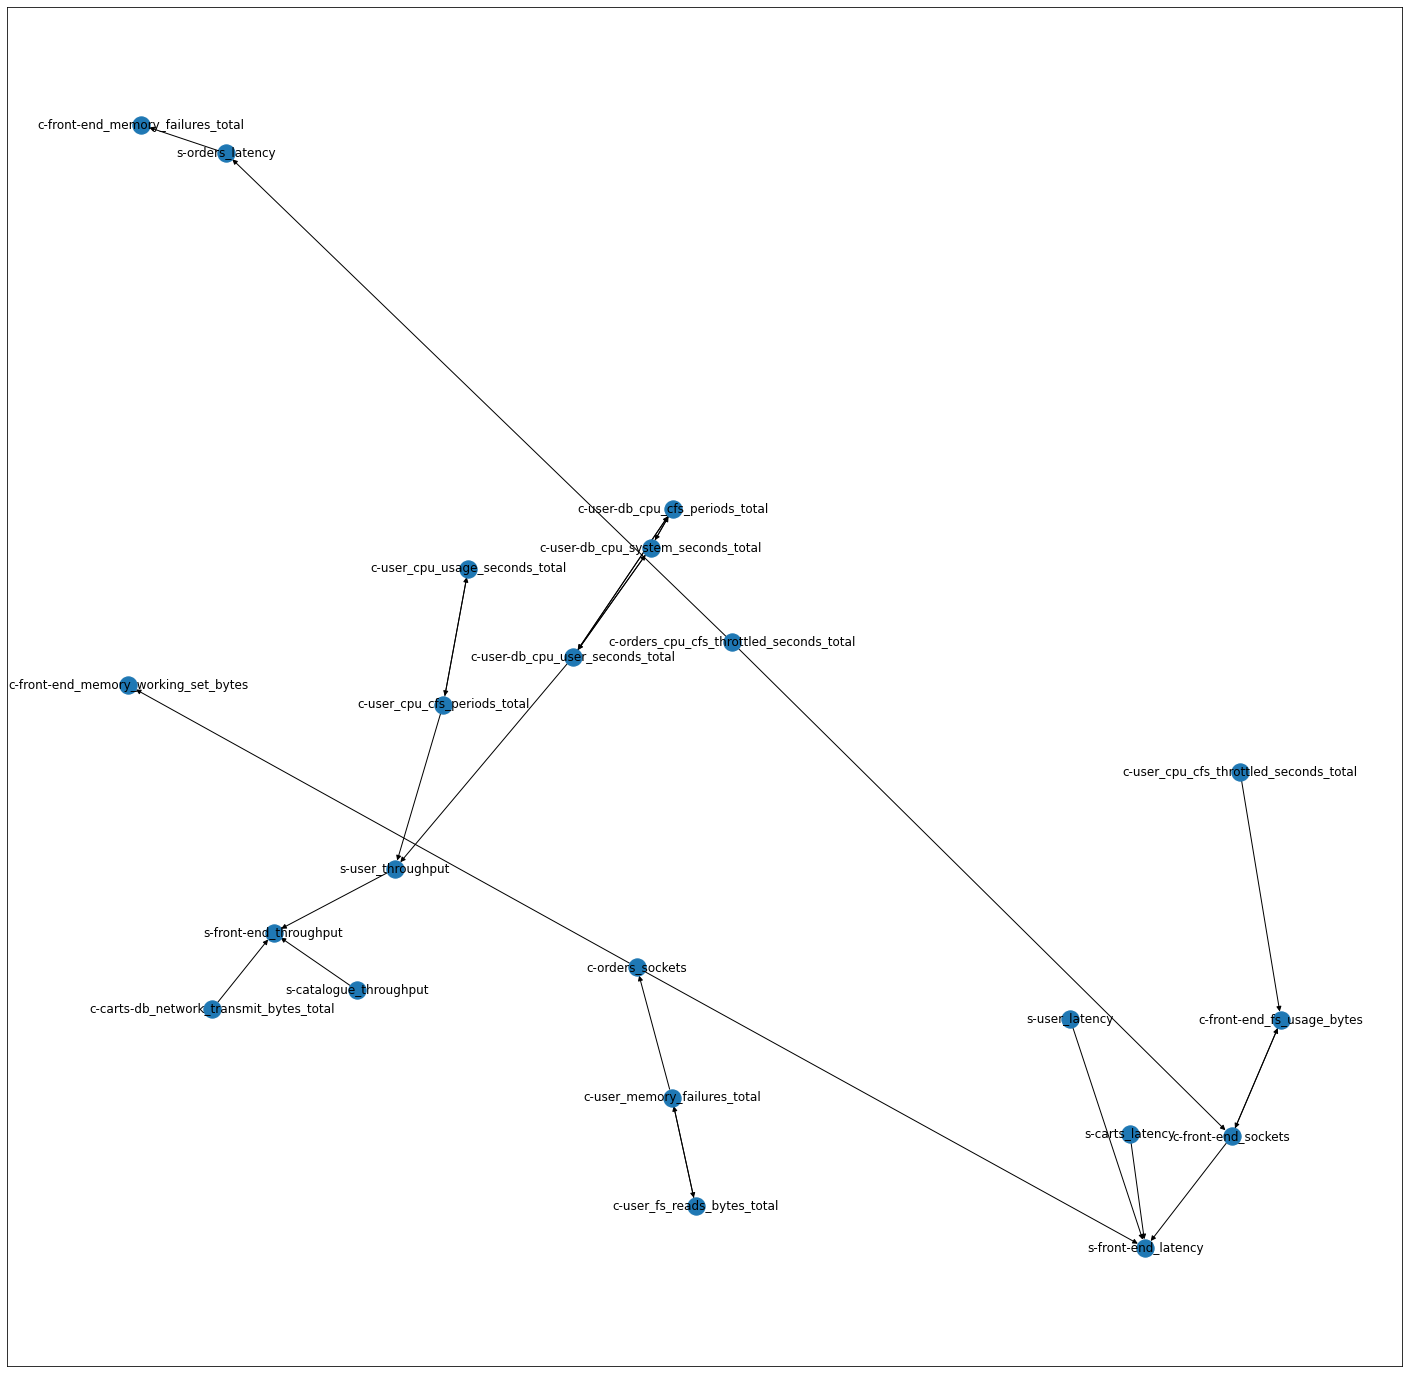

In [8]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pcalg
from diagnoser.citest.fisher_z import ci_test_fisher_z
from diagnoser.citest.pearsonar import ci_test_pearsonar
from eval import groundtruth
from gsq.ci_tests import ci_test_bin, ci_test_dis

relabeled_init_g = nx.relabel_nodes(init_g, mapping=nodes.node_to_num)
dm = dataset.to_numpy()
cm = np.corrcoef(dm.T)
(G, sep_set) = pcalg.estimate_skeleton(
    indep_test_func=ci_test_pearsonar,
    data_matrix=dm,
    alpha=0.05,
    corr_matrix=cm,
    init_graph=relabeled_init_g,
    method='stable',
)
DG: nx.DiGraph = pcalg.estimate_cpdag(skel_graph=G, sep_set=sep_set)
DG = nx.relabel_nodes(DG, mapping=nodes.num_to_node)
DG = diag.fix_edge_directions_in_causal_graph(DG)
DG = diag.remove_nodes_subgraph_uncontained_root(DG)
graph_ok, routes = groundtruth.check_causal_graph(DG, 'pod-memory-hog', 'user')
print(graph_ok, routes)
fig = plt.figure(1, figsize=(25, 25))
nx.draw_networkx(DG, node_size=300, pos=nx.spring_layout(DG))
print(DG)


Working for n conditional variables: 5: 100%|██████████| 5/5 [00:20<00:00,  4.09s/it]/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/notebooks/../diagnoser/PC.py:371: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 5: 100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


DiGraph with 82 nodes and 91 edges


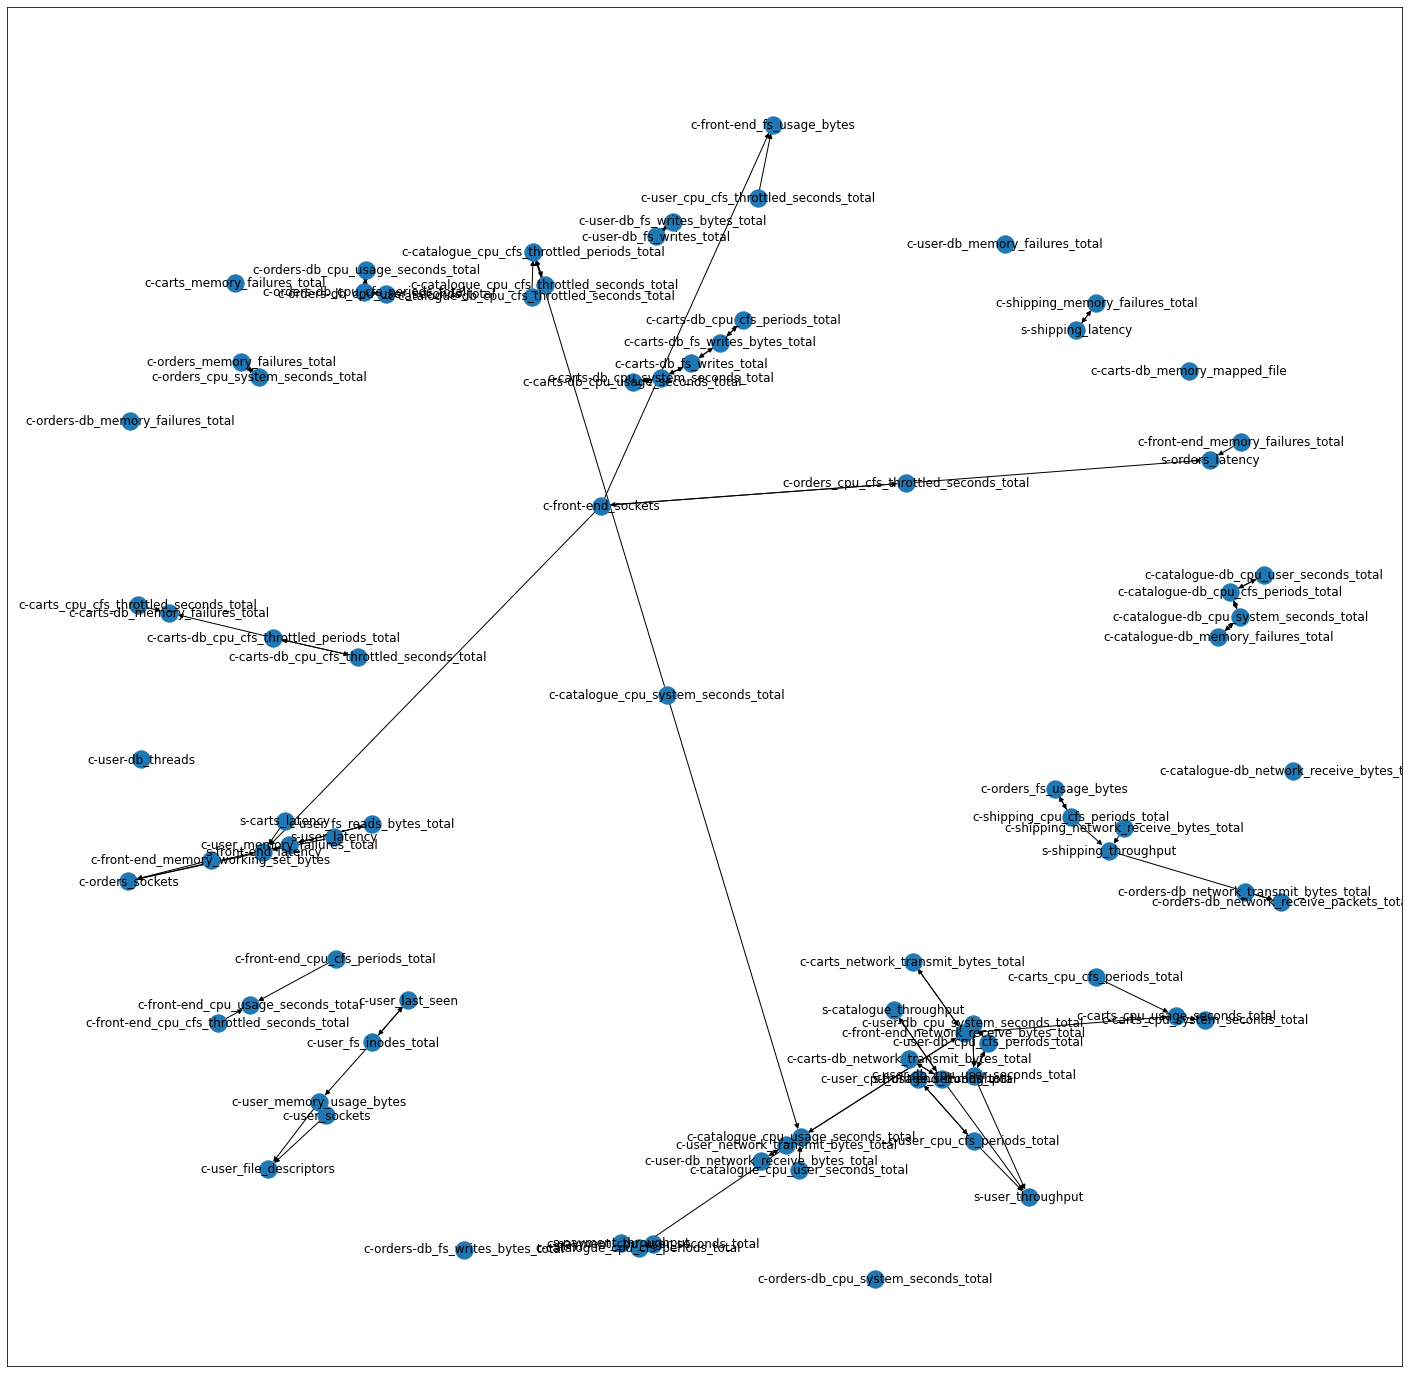

In [5]:
from diagnoser.citest.fisher_z_pgmpy import fisher_z
from pgmpy import estimators
from diagnoser.PC import PC

relabeled_init_label_g = mn.relabel_graph_nodes_to_label(init_g)
c = PC(data=dataset)
G = c.build_skeleton(
    init_graph=relabeled_init_label_g,
    variant='stable',
    ci_test='pearsonr',
    significance_level=0.05,
    return_type='pdag',
)
# DG: nx.DiGraph = pcalg.estimate_cpdag(skel_graph=G, sep_set=sep_set)
# DG = nx.relabel_nodes(G, mapping=nodes.num_to_node)
print(DG)
DG = diag.fix_edge_directions_in_causal_graph(DG)
DG = diag.remove_nodes_subgraph_uncontained_root(DG)
graph_ok, routes = groundtruth.check_causal_graph(DG, 'pod-memory-hog', 'user')
print(graph_ok, routes)
fig = plt.figure(1, figsize=(25, 25))
nx.draw_networkx(DG, node_size=300, pos=nx.spring_layout(DG))